## IC序列大阈值选股

1. 读取本地数据
2. 获取每日IC的DataFrame
3. 设置IC阈值
4. 选出因子值最大的n只股票
5. 位移与转换格式
6. 回测绩效

## 1_读取本地数据

In [1]:
from jaqs.data.dataapi import DataApi
from jaqs.data import DataView
import numpy as np
from datetime import datetime
import pandas as pd
import warnings
import alphalens

warnings.filterwarnings("ignore")
dataview_folder = 'JAQS_Data/hs300'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Dataview loaded successfully.


In [2]:
def change_index(signal):
    signal.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , signal.index))
    return signal

In [3]:
big_factor = ['roe','roa']

In [4]:
PN = pd.Panel({name: change_index(dv.get_ts(name)) for name in big_factor})

In [5]:
prices = change_index(dv.get_ts('close_adj'))

## 2_获取每日IC的DataFrame

In [16]:
def cal_daily_ic(factor_df):
    factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor_df.stack(), prices, quantiles=5, periods=(5,))
    return alphalens.performance.mean_information_coefficient(factor_data, by_time='D')
daily_ic = {key: cal_daily_ic(value) for key, value in PN.iteritems()}

In [7]:
ic_df = pd.DataFrame({factor: daily_ic.get(factor)[5] for factor in big_factor})

In [8]:
print(ic_df.head())

                 roa       roe
date                          
2012-01-04 -0.022573  0.095570
2012-01-05 -0.012033 -0.010591
2012-01-06 -0.028648  0.082105
2012-01-09 -0.138597  0.084739
2012-01-10 -0.177690  0.068066


In [9]:
df_ic = ic_df.rename_axis(lambda s: s.year*10000+s.month*100+s.day)

## 3_设置IC阈值

In [10]:
import numpy as np
def cal_big(big_ic, limit_ic=0.02):
    # 设置IC阈值为-limit_ic
    big_df = big_ic.copy()
    big_df[big_df<limit_ic]=np.nan
    big_df[big_df>=limit_ic]=1
    return big_df

## 4_选出因子值最大的n只股票

In [11]:
def big_select(rows, n=10):
    # 只选最小的n只
    time, row = rows
    row = row.dropna().index
    dct = {}
    if len(row) == 0:
        return dct
    
    target = pd.DataFrame({factor: dv.get_ts(factor, end_date=time).iloc[-1].dropna().T for factor in row})
    for name, s in target.iteritems():
        for code in s.nlargest(n).index:
            dct[code] = 1
    return dct

## 5_位移与转换格式

In [12]:
select_big = pd.DataFrame(list(map(big_select, cal_big(df_ic).iterrows())), index=PN.major_axis[5:])

In [13]:
from datetime import timedelta

def change_columns_time(signal):
    new_names = {}
    for c in signal.columns:
        if c.endswith('SZ'):
            new_names[c] = c.replace('SZ', 'XSHE')
        elif c.endswith('SH'):
            new_names[c] = c.replace('SH', 'XSHG')
    signal = signal.rename_axis(new_names, axis=1)
    signal.index = pd.Index(map(lambda x: x+timedelta(hours=15) , signal.index))
    return signal

In [14]:
big_df = change_columns_time(select_big)

## 6_回测绩效

         when using: `python -m better_exceptions'. Otherwise, only code
         loaded from files will be inspected!


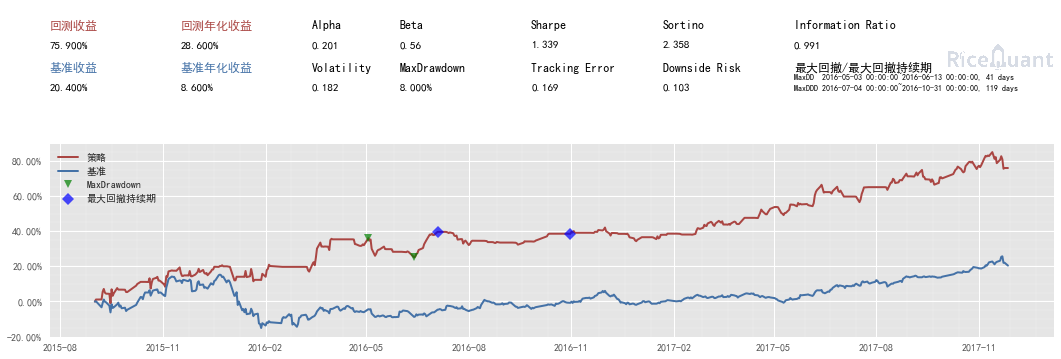

{'sys_analyser': {'benchmark_portfolio':                cash  market_value  static_unit_net_value  total_value  \
  date                                                                    
  2015-09-01  1462.24     998537.76                  1.000   1000000.00   
  2015-09-02  1462.24     999651.51                  1.000   1001113.75   
  2015-09-07  1462.24     965392.56                  1.001    966854.80   
  2015-09-08  1462.24     990203.94                  0.967    991666.18   
  2015-09-09  1462.24    1009595.07                  0.992   1011057.31   
  2015-09-10  1462.24     997195.32                  1.011    998657.56   
  2015-09-11  1462.24     994115.43                  0.999    995577.67   
  2015-09-14  1462.24     974495.61                  0.996    975957.85   
  2015-09-15  1462.24     936212.31                  0.976    937674.55   
  2015-09-16  1462.24     982847.25                  0.938    984309.49   
  2015-09-17  1462.24     961389.00                  0.984   

In [15]:
import numpy as np
import talib as ta
import pandas as pd
import rqalpha
from rqalpha.api import *

#读取文件位置
def init(context):
    context.codes = big_df
    context.stocks = []
#     scheduler.run_weekly(find_pool, tradingday=1)
    scheduler.run_daily(find_pool)

def find_pool(context, bar_dict):
    try:
        codes = context.codes.loc[context.now]
    except KeyError:
        return
    stocks = codes.index[codes == 1]
    context.stocks = stocks

def handle_bar(context, bar_dict):
    buy(context, bar_dict)
    
    
def buy(context, bar_dict):
    pool = context.stocks
    if pool is not None:
        stocks_len = len(pool)
        for stocks in context.portfolio.positions:
            if stocks not in pool:
                order_target_percent(stocks, 0)
        result = []
        for codes in pool:
            if codes not in result and codes not in context.portfolio.positions:
                result.append(codes)
        if len(result):
            for r in result:
                order_target_percent(r, 1.0/stocks_len)

config = {
  "base": {
    "start_date": "2015-09-01",
    "end_date": "2017-12-22",
    "accounts": {'stock':1000000},
    "benchmark": "000300.XSHG"
  },
  "extra": {
    "log_level": "error",
  },
  "mod": {
    "sys_analyser": {
      "enabled": True,
      "plot": True
    }
  }
}

rqalpha.run_func(init=init, handle_bar=handle_bar, config=config)